In [1]:
import os
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import pandas as pd
import random
from src.utils import plot_graph, prepare_graph, analyze_graph, random_walk, random_diffusion
from src.crud import get_author_to_author, get_distinct_authors
from src.config import get_db_connection
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

USE_MINI = False

In [2]:
if USE_MINI:
    db_path = "../../../data/twitter_small.db"
else:
    db_path = "../../../data/twitter.db"
con = get_db_connection(db_path=db_path, use_dict_reponses=False)
reply_edges = get_author_to_author(con, response_type="replied_to")
con.close()
con = get_db_connection(db_path=db_path)
authors = get_distinct_authors(con)
con.close()
print(f"num vertices: {len(authors)}")
print(reply_edges[:3])
pd.DataFrame(reply_edges).head()

num vertices: 481467
[('307001802', '41077970'), ('786625296', '338985020'), ('2431501916', '16717501')]


,0,1
0,307001802,41077970
1,786625296,338985020
2,2431501916,16717501
3,3181309406,26735736
4,2349646720,130509788


Order: 24553
Size: 28827
No .of Components: 1
Size of largest component: 24553
Density: 9.563965581428792e-05
Transitivity: 0.21998502913719503


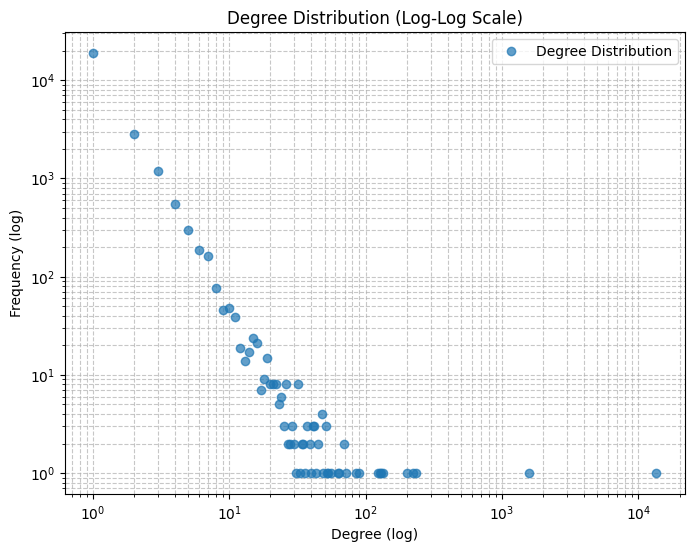

In [3]:
reply_graph = ig.Graph(len(authors))
reply_graph["title"] = "reply network"
reply_graph.vs["name"] = authors
reply_graph.add_edges(reply_edges)
reply_graph, rp_layout = prepare_graph(
    reply_graph,
    layout=reply_graph.layout_fruchterman_reingold(niter=100),
)
g = reply_graph.components().giant()
analyze_graph(g)

# Task 3.1

In [4]:
token_ratios = random_walk(g, iterations= 2 * g.vcount())
g.vs["token_ratios"] = token_ratios

In [ ]:
# todo, get other datasets (barabasi, swg, erg etc)

In [ ]:
datasets = {
    "g": g.vs["token_ratios"],
    "swg": swg.vs["token_ratios"],
    "bag": bag.vs["token_ratios"],
    "erg": erg.vs["token_ratios"],
    "rewired": rewired.vs["token_ratios"],
}

num_datasets = len(datasets)
fig, axes = plt.subplots(nrows=num_datasets, ncols=1, figsize=(8, 6 * num_datasets), sharex=True)
for ax, (label, data) in zip(axes, datasets.items()):
    ax.hist(data, bins=30, density=True, color="skyblue", edgecolor="black", alpha=0.7, label="Histogram")

    kde = gaussian_kde(data)
    x = np.linspace(min(data), max(data), 1000)
    ax.plot(x, kde(x), color="darkblue", linewidth=2, label="KDE")

    ax.set_title(f"Distribution of Reply Tokens ({label})", fontsize=16)
    ax.set_xlabel("Value", fontsize=14)
    ax.set_yscale("log")
    ax.set_ylabel("Density (log scale)", fontsize=14)

    ax.legend(fontsize=12)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Task 3.2
#### Function Requirements
1. **Inputs**:
   - `graph`: The network structure.
   - `start`: Initial actor to start diffusion.
   - `iterations`: Number of diffusion rounds.
   - `beta`: Probability of passing the information.

2. **Process**:
   - At each iteration:
     - All `+` actors attempt to spread information to their neighbors.
     - Each neighbor switches to `+` with probability `beta`.

3. **Output**:
   - Return the total count of `+` actors after all iterations.

#### Experiment
Run the function on five networks and analyze:
- Factors that increase/decrease diffusion speed (e.g., network structure, `beta`, initial starting point).

In [9]:
_ = random_diffusion(g, iterations=1000)
print(f"{len(_[0]) / g.vcount()}%")
print(_[1])

0infected=3
1infected=8612
2infected=15181
3infected=20360
4infected=22746
5infected=23820
6infected=24255
7infected=24439
8infected=24513
9infected=24537
10infected=24545
11infected=24549
12infected=24551
13infected=24552
14infected=24553
All nodes infected after 14 rounds.


TypeError: object of type 'int' has no len()

In [ ]:
# Todo: loop datasets and bootstrap count of infected individuals, plot their distributions

# Task 3.3
#### Task
Simulate an opinion diffusion process where:
- Actors have two states: `+` (opinion positive) and `-` (opinion negative).
- Initially, all actors have opinion `-`.
  
#### Function Requirements
1. **Inputs**:
   - `graph`: The network structure.
   - `initial_positive`: Number of actors whose opinion is set to `+` initially.
   - `iterations`: Number of diffusion rounds.
   - `th`: Opinion change threshold.

2. **Process**:
   - At each iteration:
     - Actors with state `+` count their neighbors' opinions.
     - If the proportion of `-` neighbors is greater than or equal to the threshold `th`, the actor switches to opinion `-`.

3. **Output**:
   - Return the count of actors with opinion `+` after all iterations.

#### Experiment
Run the function on five networks and analyze:
- Factors that affect the speed of opinion adoption (e.g., network structure, `th`, initial conditions).
